In [206]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(1)
XBASIS = False
ROUNDS = 50

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")


# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]
md = md[md['resets'].isna()]

# md = md[0:1]
print("shape:", md.shape)
md[:2]


state = Z1
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5058,2024-03-23 14:08:33.452000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzd8maktf3g00883pb0,"[Subset 52, 50 rounds, 1 log, xbasis=False]",1.0,1507.0,NaN,JobStatus.DONE,2024-03-23 15:24:25.172305+01:00,RepetitionCodeCircuit,52,50,1,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."
5057,2024-03-23 14:08:26.158000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzd8jaktf3g00883pag,"[Subset 52, 50 rounds, 1 log, xbasis=False]",1.0,1507.0,NaN,JobStatus.DONE,2024-03-23 15:23:54.910800+01:00,RepetitionCodeCircuit,52,50,1,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."


In [207]:
from result_saver import SaverProvider

provider = SaverProvider()

In [208]:
md_loc = 0

job_id = md.iloc[md_loc]["job_id"]
job = provider.retrieve_job(job_id) 

execution_date = job.result().date
memory = job.result().get_memory()

print(f"Execution date: {execution_date}")

Execution date: 2024-03-23 15:24:25.172305+01:00


In [261]:
# assert md_loc == -1
# for id in range(-5, -1):
#     job = provider.retrieve_job(md.iloc[id]["job_id"])
#     memory = np.vstack([memory, job.result().get_memory()])

assert md_loc == 0
for id in range(1, 1):
    job = provider.retrieve_job(md.iloc[id]["job_id"])
    memory = np.vstack([memory, job.result().get_memory()])

# Needed decoding objects

#### KDE

In [262]:
import numpy as np

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[md_loc]["rounds"]
d = md.iloc[md_loc]["distance"]

shots = md.iloc[md_loc]["shots"]

rel_error = 1

# KDE BANDWIDTHS
lin = [0.1, 0.7, 30]
num_points = 51
bandwidths = np.linspace(lin[0], lin[1], lin[2])

In [263]:
from soft_info import get_repcode_IQ_map
from soft_info import inv_qubit_mapping
from Scratch import load_calibration_memory
from src import cpp_soft_info
from datetime import datetime

all_memories, gmm_dict, msmt_err_dict = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                other_date=execution_date, post_process=True,
                                                                double_msmt=False)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwidths, relError=rel_error, absError=-1, num_points=num_points)

all_memories_PS, gmm_dict_PS, msmt_err_dict_PS = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                other_date=execution_date, post_process=True,
                                                                double_msmt=True)

kde_dict_PS = cpp_soft_info.get_KDEs(all_memories_PS, bandwidths, relError=rel_error, absError=-1, num_points=num_points)

Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 14:24:57.025236+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 14:26:06.755754+00:00.


In [264]:
# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

pSoft, countMat, estim0Mat, estim1Mat = cpp_soft_info.iqConvertorEstim(memory, inverted_q_map, kde_dict, rel_error)

#### KDE_PS

In [265]:
pSoftPS, countMatPS, estim0MatPS, estim1MatPS = cpp_soft_info.iqConvertorEstim(memory, inverted_q_map, kde_dict_PS, rel_error)

#### Gaussian

In [266]:
from soft_info import gaussianIQConvertor

countMatG, pSoftG = gaussianIQConvertor(memory, inverted_q_map, gmm_dict)

# find ambigous points

In [267]:
print({key: len(value) for key, value in inverted_q_map.items()})

{23: 50, 25: 50, 27: 50, 35: 50, 48: 50, 50: 50, 36: 50, 31: 50, 17: 50, 11: 50, 9: 50, 7: 50, 5: 50, 3: 50, 1: 50, 14: 50, 19: 50, 33: 50, 40: 50, 42: 50, 44: 50, 54: 50, 65: 50, 67: 50, 69: 50, 74: 50, 88: 50, 86: 50, 84: 50, 92: 50, 103: 50, 105: 50, 107: 50, 112: 50, 125: 50, 123: 50, 121: 50, 119: 50, 110: 50, 99: 50, 91: 50, 80: 50, 72: 50, 61: 50, 59: 50, 71: 50, 76: 50, 90: 50, 95: 50, 109: 50, 115: 50, 22: 1, 24: 1, 26: 1, 28: 1, 47: 1, 49: 1, 51: 1, 32: 1, 30: 1, 12: 1, 10: 1, 8: 1, 6: 1, 4: 1, 2: 1, 0: 1, 18: 1, 20: 1, 39: 1, 41: 1, 43: 1, 45: 1, 64: 1, 66: 1, 68: 1, 70: 1, 89: 1, 87: 1, 85: 1, 83: 1, 102: 1, 104: 1, 106: 1, 108: 1, 126: 1, 124: 1, 122: 1, 120: 1, 118: 1, 100: 1, 98: 1, 79: 1, 81: 1, 62: 1, 60: 1, 58: 1, 77: 1, 75: 1, 94: 1, 96: 1, 114: 1, 116: 1}


In [272]:
qubit = 9
cols = inverted_q_map[qubit]

mmr_sub = memory[:, cols]
pSoft_sub = pSoft[:, cols]
pSoftPS_sub = pSoftPS[:, cols]
pSoftG_sub = pSoftG[:, cols]
countMat_sub = countMat[:, cols]
countMatPS_sub = countMatPS[:, cols]
countMatG_sub = countMatG[:, cols]
estimate0_sub = estim0Mat[:, cols]
estimate1_sub = estim1Mat[:, cols]
estimate0PS_sub = estim0MatPS[:, cols]
estimate1PS_sub = estim1MatPS[:, cols]


threshold = 1e-2
mask = ~((estimate0_sub < threshold) & (estimate1_sub < threshold))
maskPS = ~((estimate0PS_sub < threshold) & (estimate1PS_sub < threshold))

maskBiased = (np.abs(estimate0_sub - estimate1_sub)/np.abs(estimate0_sub + estimate1_sub) > 0.1)
# maskBiasedPS = (np.abs(estimate0PS_sub - estimate1PS_sub)/np.abs(estimate0PS_sub + estimate1PS_sub) > 0.)
maskBiasedPS = (np.abs(estimate0PS_sub - estimate1PS_sub) > 0.2)

mask_tot = mask & maskBiased
mask_totPS = maskPS & maskBiasedPS



In [273]:
# import matplotlib.pyplot as plt

# estim0PSmask = estimate0PS_sub[mask]
# estim1PSmask = estimate1PS_sub[mask]
# estim0mask = estimate0_sub[mask]
# estim1mask = estimate1_sub[mask]


# color_estim0 = 'blue'
# color_estim1 = 'red'
# color_estimN0 = 'green'
# color_estimN1 = 'yellow'
# bins = 50  # Adjust the number of bins based on your data distribution
# plt.figure(figsize=(10, 6))
# # plt.hist(estim0PSmask, bins=bins, alpha=0.5, color=color_estim0, label='Estim0 PS')
# # plt.hist(estim1PSmask, bins=bins, alpha=0.5, color=color_estim1, label='Estim1 PS')
# plt.hist(estim0mask, bins=bins, alpha=0.5, color=color_estimN0, label='Estim0')
# plt.hist(estim1mask, bins=bins, alpha=0.5, color=color_estimN1, label='Estim1')

# plt.xlabel('Estimation Values')
# plt.ylabel('Frequency')
# plt.title(f'PS | qubit {qubit}')
# plt.legend(loc='upper right')

# plt.show()





13:28:05 Warning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 115


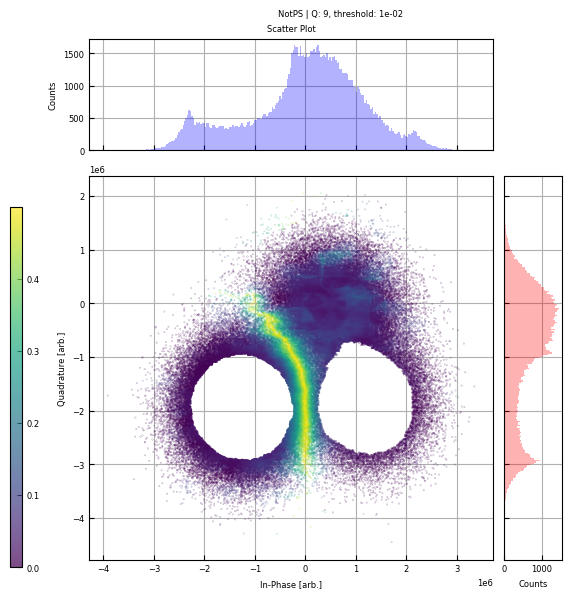

13:28:06 Warning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 115


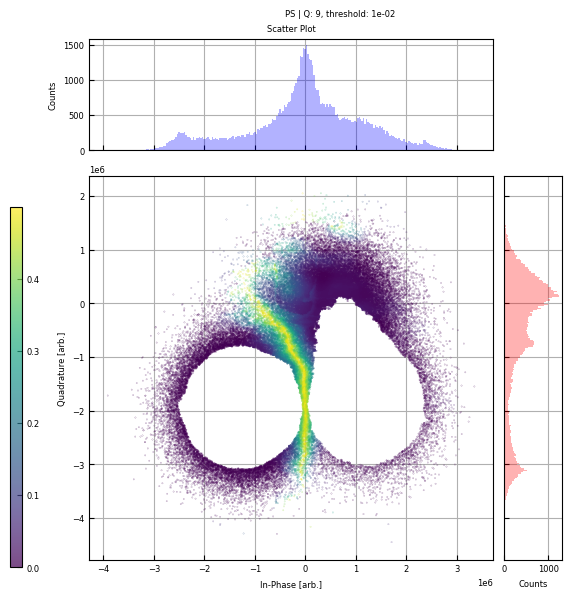

In [274]:
from soft_info import plot_IQ_data_pSoft_cmap

plot_IQ_data_pSoft_cmap(mmr_sub[~mask], pSoft_sub[~mask], figsize=(6,6), title=f"NotPS | Q: {qubit}, threshold: {threshold:.0e}")
plot_IQ_data_pSoft_cmap(mmr_sub[~maskPS], pSoftPS_sub[~maskPS], figsize=(6,6), title=f"PS | Q: {qubit}, threshold: {threshold:.0e}")
# plot_IQ_data_pSoft_cmap(mmr_sub[~mask_tot], pSoft_sub[~mask_tot], figsize=(6,6), title=f"NotPS | Q: {qubit}, threshold: {threshold:.0e}")
# plot_IQ_data_pSoft_cmap(mmr_sub[~mask_totPS], pSoftPS_sub[~mask_totPS], figsize=(6,6), title=f"PS | Q: {qubit}, threshold: {threshold:.0e}")

# plot the counts

In [ ]:
# from soft_info import plot_IQ_data_with_countMat

# qubit = 69
# leaked_qubits = [3, 9, 28, 50, 54, 61, 69, 80, 86, 91, 99, 107, 125]
# for qubit in leaked_qubits:
#     cols = inverted_q_map[qubit]

#     mmr_sub = memory[:, cols]
#     pSoft_sub = pSoft[:, cols]
#     pSoftPS_sub = pSoftPS[:, cols]
#     pSoftG_sub = pSoftG[:, cols]
#     countMat_sub = countMat[:, cols]
#     countMatPS_sub = countMatPS[:, cols]
#     countMatG_sub = countMatG[:, cols]
#     estimate0_sub = estim0Mat[:, cols]
#     estimate1_sub = estim1Mat[:, cols]
#     estimate0PS_sub = estim0MatPS[:, cols]
#     estimate1PS_sub = estim1MatPS[:, cols]


#     threshold = 1e-3
#     mask = ~((estimate0_sub < threshold) & (estimate1_sub < threshold))
#     maskPS = ~((estimate0PS_sub < threshold) & (estimate1PS_sub < threshold))



#     antimask = ~mask
#     antimaskPS = ~maskPS

#     plot_IQ_data_with_countMat(mmr_sub[antimask], countMat_sub[antimask], figsize=(6,6), title=f"NotPS | Q: {qubit}, threshold: {threshold:.0e}")
#     plot_IQ_data_with_countMat(mmr_sub[antimaskPS], countMatPS_sub[antimaskPS], figsize=(6,6), title=f"PS | Q: {qubit}, threshold: {threshold:.0e}")

13:17:30 Warning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 234


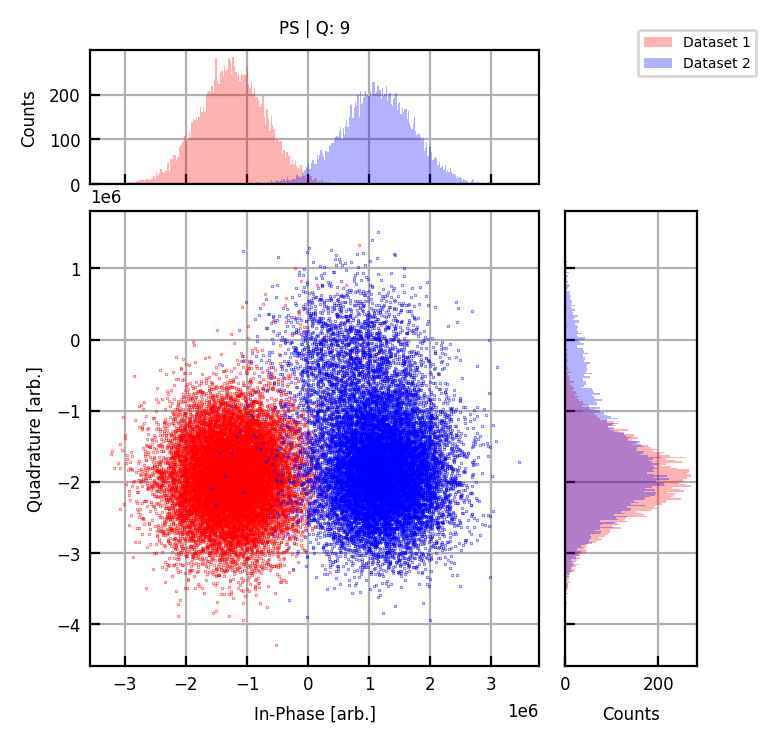

In [257]:
from soft_info import plot_multiple_IQ_data

plot_multiple_IQ_data([all_memories_PS[qubit]['mmr_0'], all_memories_PS[qubit]['mmr_1']], title=f"PS | Q: {qubit}")

# Plot the pSoft cmap

07:17:15 Warning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 115


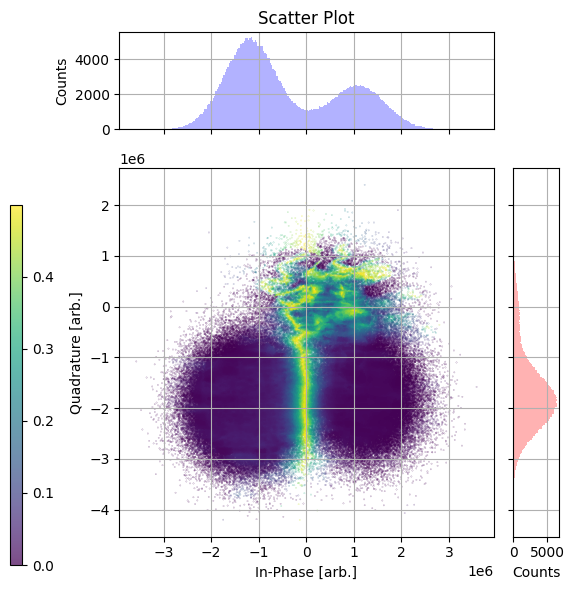

07:17:17 Warning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 115


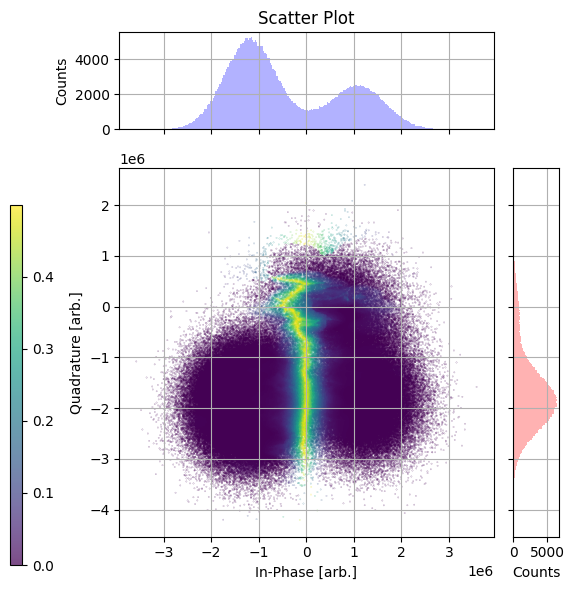

In [ ]:
from soft_info import plot_IQ_data_pSoft_cmap
qubit = 9
cols = inverted_q_map[qubit]

mmr_sub = memory[:, cols]

pSoft_sub = pSoft[:, cols]
pSoftPS_sub = pSoftPS[:, cols]
pSoftG_sub = pSoftG[:, cols]
countMat_sub = countMat[:, cols]
countMatPS_sub = countMatPS[:, cols]
countMatG_sub = countMatG[:, cols]
estimate0_sub = estim0Mat[:, cols]
estimate1_sub = estim1Mat[:, cols]
estimate0PS_sub = estim0MatPS[:, cols]
estimate1PS_sub = estim1MatPS[:, cols]

plot_IQ_data_pSoft_cmap(mmr_sub, pSoft_sub, figsize=(6,6))
plot_IQ_data_pSoft_cmap(mmr_sub, pSoftPS_sub, figsize=(6,6))

# Statistics pSoft

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data1 = pSoft.flatten() * 100  
mean1 = np.mean(data1)  
std1 = np.std(data1)  

data2 = pSoftG.flatten() * 100  
mean2 = np.mean(data2)
std2 = np.std(data2)
print(mean2, std2)

data3 = pSoftPS.flatten() * 100  
mean3 = np.mean(data3)
std3 = np.std(data3)

plt.figure(dpi=150)

bins = 100
alpha = 0.5
density = True
# plt.hist(data1, bins=bins, density=density, alpha=alpha, color='g', label='pSoft from KDEs')
plt.hist(data3, bins=bins, density=density, alpha=alpha, color='r', label='pSoft from KDE_PS')
plt.hist(data2, bins=bins, density=density, alpha=alpha, color='b', label='pSoft from GMMs')  


plt.ylabel("Density")
plt.xlabel("pSoft (%)")
plt.grid()

# # Plot the means as vertical lines
# plt.axvline(mean1, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean1:.2f}%')
# plt.axvline(mean3, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean3:.2f}%')
# plt.axvline(mean2, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean2:.2f}%')  

# # Plot the standard deviations as error bars
# plt.errorbar(mean1, plt.ylim()[1] * 0.9, xerr=std1, fmt='o', color='green', capsize=5, label=f'Std: {std1:.2f}')
# plt.errorbar(mean3, plt.ylim()[1] * 0.7, xerr=std3, fmt='o', color='red', capsize=5, label=f'Std: {std3:.2f}')
# plt.errorbar(mean2, plt.ylim()[1] * 0.8, xerr=std2, fmt='o', color='blue', capsize=5, label=f'Std: {std2:.2f}')  

# plt.ylim(0, 0.02)
# plt.xlim(0, 0.15)

plt.yscale('log')

date_str = md.iloc[md_loc]['execution_date']
execution_date = datetime.fromisoformat(date_str)
formatted_date = execution_date.strftime('%Y-%m-%d')
plt.title(f"{formatted_date} {DEVICE}, {state}, Rounds {ROUNDS},  \nshots: {memory.shape[0]}")
plt.legend()
plt.show()
